In [58]:
from model import *
from data import *
from helpers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os


# set device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']



In [59]:
# simulate data
if cfg['simulate']:
    theta=np.random.normal(0,1,cfg['N']*cfg['mirt_dim']).reshape((cfg['N'], cfg['mirt_dim']))
    Q = pd.read_csv(f'parameters/QMatrix{cfg["mirt_dim"]}D.csv', header=None, dtype=float).values

    a = np.random.uniform(.5, 2, Q.shape[0] * cfg['mirt_dim']).reshape((Q.shape[0], cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
    a *= Q
    b = np.linspace(-2, 2, Q.shape[0], endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty
    exponent = np.dot(theta, a.T) + b

    prob = np.exp(exponent) / (1 + np.exp(exponent))
    data = np.random.binomial(1, prob).astype(float)
else:
    data = pd.read_csv(f'./data/simulated/data_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    a = pd.read_csv(f'./parameters/simulated/a_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    b = pd.read_csv(f'./parameters/simulated/b_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    theta = pd.read_csv(f'./parameters/simulated/theta_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', header=None, index_col=False).to_numpy()
    Q = pd.read_csv(f'./parameters/QMatrix{cfg["mirt_dim"]}D.csv', header=None).values

# potentially save data to disk
if cfg['save']:
    np.savetxt(f'./data/simulated/data_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', data, delimiter=",")
    np.savetxt(f'./parameters/simulated/a_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', a, delimiter=",")
    np.savetxt(f'./parameters/simulated/b_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', b, delimiter=",")
    np.savetxt(f'./parameters/simulated/theta_{cfg["mirt_dim"]}_{cfg["iteration"]}.csv', theta, delimiter=",")

# introduce missingness
np.random.seed(cfg['iteration'])
indices = np.random.choice(data.shape[0]*data.shape[1], replace=False, size=int(data.shape[0]*data.shape[1]*cfg['missing_percentage']))
data[np.unravel_index(indices, data.shape)] = float('nan')
data = torch.Tensor(data)

# X = pd.read_csv('./data/missing/data.csv', index_col=0).to_numpy()
# a = pd.read_csv('./data/missing/a.csv', index_col=0).to_numpy()
# theta = pd.read_csv('./data/missing/theta.csv', index_col=0).to_numpy()
# d = pd.read_csv('./data/missing/d.csv', index_col=0).to_numpy()
# Q = (a != 0).astype(int)


# initialise model and optimizer
logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=cfg['max_epochs'],
                  enable_checkpointing=False, 
                  logger=False, 
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])

if cfg['model'] == 'cvae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = CVAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size'],
               hidden_layer_size2=cfg['hidden_layer_size2'],
               hidden_layer_size3=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
elif cfg['model'] == 'idvae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = IDVAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
elif cfg['model'] == 'ivae':
    vae = IVAE(nitems=data.shape[1],
               data=data,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],#cfg['batch_size']
               i_miss=indices,
    )
elif cfg['model'] == 'pvae':
    dataset = PartialDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = PVAE(dataloader=train_loader,
               nitems=Q.shape[0],
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],
               emb_dim=cfg['p_emb_dim'],
               h_hidden_dim=cfg['p_hidden_dim'],
               latent_dim=cfg['p_latent_dim'],
               hidden_layer_dim=cfg['p_hidden_layer_dim'],
               mirt_dim=cfg['mirt_dim'],
               Q=Q,
               beta=1
    )
elif cfg['model'] == 'iwae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = IWAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size'],
               hidden_layer_size2=cfg['hidden_layer_size2'],
               hidden_layer_size3=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0],
               n_samples=cfg['n_iw_samples']
    )
elif cfg['model'] == 'vae':
    dataset = SimDataset(data)
    train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
    vae = VAE(nitems=data.shape[1],
               dataloader=train_loader,
               latent_dims=cfg['mirt_dim'],
               hidden_layer_size=cfg['hidden_layer_size2'],
               hidden_layer_size2=cfg['hidden_layer_size3'],
               qm=Q,
               learning_rate=cfg['learning_rate'],
               batch_size=data.shape[0]

    )
else:
    raise Exception("Invalid model type")



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/karel/Documents/GitHub/MIRT-VAE-QMAtrix/data.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_train = torch.tensor(X, dtype=torch.float32)


In [60]:
start = time.time()
trainer.fit(vae)
runtime = time.time()-start
print(runtime)

a_est = vae.decoder.linear.weight.detach().cpu().numpy()[:, 0:cfg['mirt_dim']]
d_est = vae.decoder.linear.bias.detach().cpu().numpy()
vae = vae.to(device)

if cfg['model'] in ['cvae', 'iwae']:
    dataset = SimDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    data, mask = next(iter(train_loader))
    theta_est, _ = vae.encoder(data, mask)
elif cfg['model'] in ['idvae', 'vae']:
    dataset = SimDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    data, mask = next(iter(train_loader))
    theta_est, _ = vae.encoder(data)
elif cfg['model'] == 'ivae':
    theta_est, _ = vae.encoder(vae.data)
elif cfg['model'] == 'pvae':
    dataset = PartialDataset(data, device)
    train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
    item_ids, ratings, _, _ = next(iter(train_loader))
    theta_est, _ = vae.encoder(item_ids, ratings)


theta_est = theta_est.detach().cpu().numpy()
if cfg['mirt_dim'] == 1:
    theta = np.expand_dims(theta, 1)
# invert factors for increased interpretability
a_est, theta_est = inv_factors(a_est=a_est, theta_est=theta_est, a_true=a)

mse_a = f'{MSE(a_est, a)}\n'
mse_d = f'{MSE(d_est, b)}\n'
mse_theta = f'{MSE(theta_est, theta)}\n'

lll = f'{loglikelihood(a_est, d_est, theta_est, data.numpy())}\n'

# print results
print(mse_a)
print(mse_d)
print(mse_theta)


  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ConditionalEncoder | 2.7 K 
1 | sampler | SamplingLayer      | 0     
2 | decoder | Decoder            | 112   
-----------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
/Users/karel/miniforge3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

62.14311909675598
0.7763984326442683

0.10903030725633614

1.0375209359255289



In [61]:
vae

CVAE(
  (encoder): ConditionalEncoder(
    (dense1): Linear(in_features=56, out_features=30, bias=True)
    (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense2): Linear(in_features=30, out_features=20, bias=True)
    (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense3): Linear(in_features=20, out_features=10, bias=True)
    (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (densem): Linear(in_features=10, out_features=3, bias=True)
    (denses): Linear(in_features=10, out_features=3, bias=True)
  )
  (sampler): SamplingLayer()
  (decoder): Decoder(
    (linear): Linear(in_features=3, out_features=28, bias=True)
    (activation): Sigmoid()
  )
)

In [63]:
theta_est, sigma_est = vae.encoder(data, mask)

In [64]:
np.savetxt("/Users/karel/Documents/VAE missing/sigma/theta_est_cvae.csv", theta_est.detach().numpy(), delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/sigma_est_cvae.csv", sigma_est.detach().numpy(), delimiter=",")

In [10]:
sigma_est.shape

torch.Size([10000, 3])

In [65]:
np.savetxt("/Users/karel/Documents/VAE missing/sigma/a_cvae.csv", a_est, delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/d_cvae.csv", d_est, delimiter=",")
np.savetxt("/Users/karel/Documents/VAE missing/sigma/data_cvae.csv", data, delimiter=",")

In [258]:
# cvae 25%
cvae25 = np.array([
 [0.6853, 0.4569, 0.7890],
 [0.6719, 0.4571, 0.7944],
 [0.6687, 0.4558, 0.7418],
 [0.6997, 0.4639, 0.7788],
 [0.6775, 0.4796, 0.7957],
 [0.6743, 0.4511, 0.7987],
 [0.6811, 0.4883, 0.7870]
])

np.mean(cvae25, 0)

array([0.67978571, 0.46467143, 0.78362857])

In [253]:
# cvae 75%
cvae75 = np.array([
 [0.8674, 0.5768, 0.9767],
 [0.8158, 0.5351, 0.9316],
 [0.8662, 0.5979,
  0.9785],
 [0.8256, 0.5538, 0.9322],
 [0.8256, 0.5538, 0.9322],
 [0.8361, 0.6410, 1.0308],
 [0.8973, 0.6350, 1.0524]
])

np.mean(cvae75, 0)

array([0.84771429, 0.58477143, 0.97634286])

In [259]:
# idvae 25%
idvae25 = np.array([
    [0.5903, 0.3629, 0.7083],
    [0.6264, 0.3551, 0.7282],
    [0.6068, 0.3717, 0.7317],
    [0.6248, 0.3501, 0.7436],
    [0.5964, 0.3601, 0.7221],
    [0.5916, 0.3705, 0.7249],
    [0.6102, 0.3708, 0.7536]
])

np.mean(idvae25, 0)

array([0.60664286, 0.36302857, 0.73034286])

In [260]:
# idvae 75%
idvae25 = np.array([
 [0.7135, 0.5397, 0.7866], 
 [0.7036, 0.5224, 0.8569],
 [0.7029, 0.5598, 0.8370],
 [0.7494, 0.3959, 0.8394],
 [0.7020, 0.4952, 0.8282],
 [0.6861, 0.5039, 0.7862],
 [0.7572, 0.5617, 0.8399]
])

np.mean(idvae25, 0)

array([0.71638571, 0.51122857, 0.82488571])

array([0.6853, 0.6719, 0.6687, 0.6997, 0.6775, 0.6743, 0.6811])

Text(0, 0.5, 'Estimates')

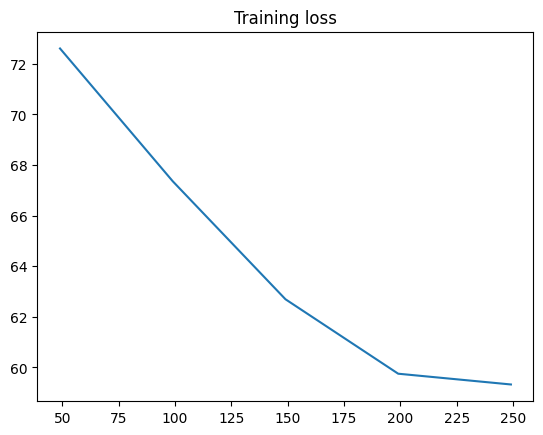

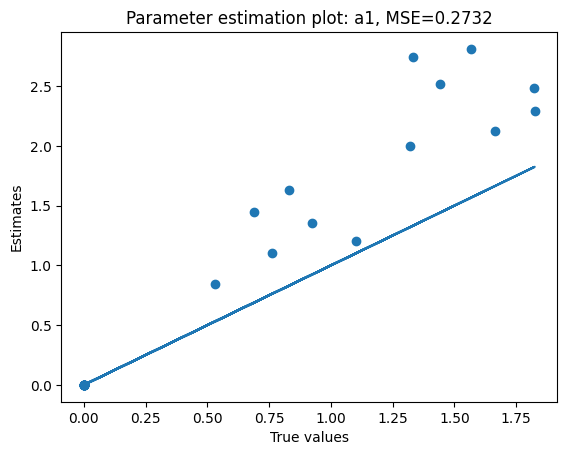

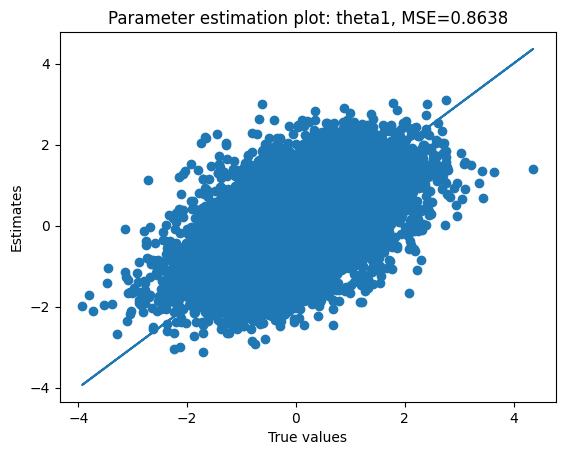

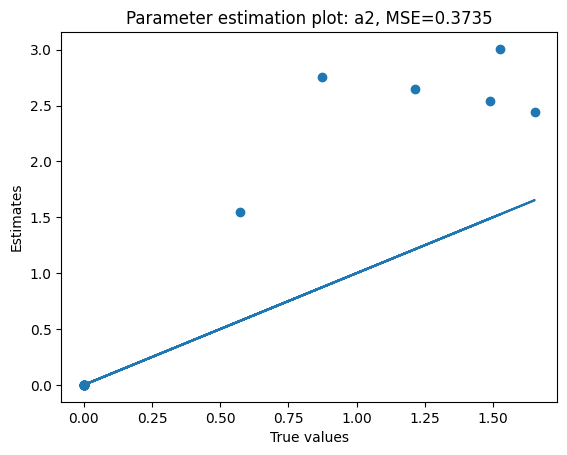

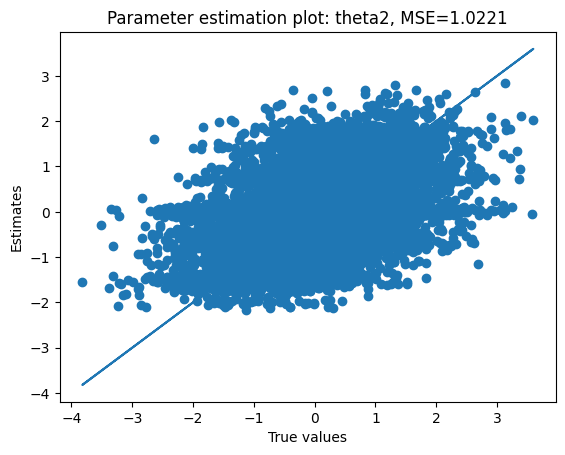

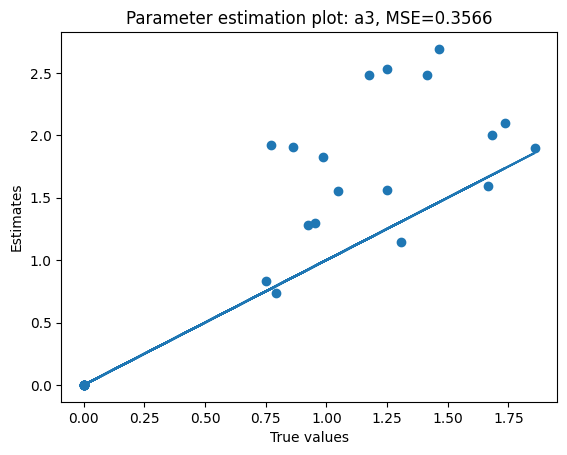

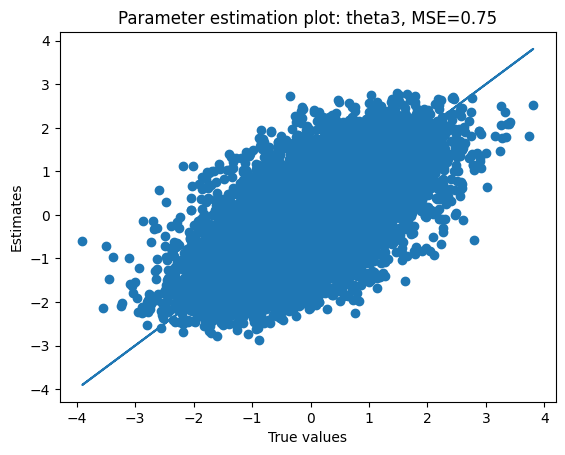

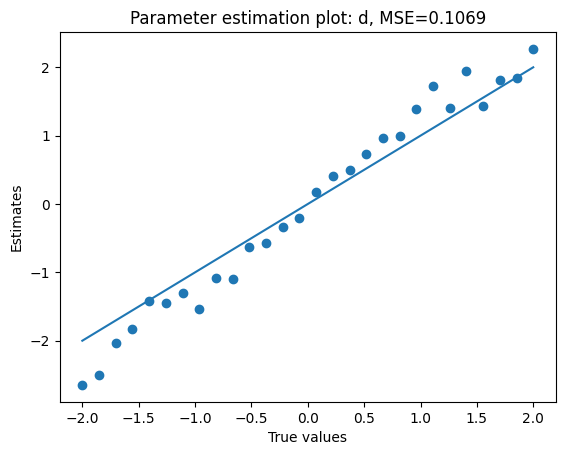

In [58]:


# plot training loss
logs = pd.read_csv(f'logs/simfit/version_0/metrics.csv')
plt.plot(logs['epoch'], logs['train_loss'])
plt.title('Training loss')
plt.savefig(f'./figures/simfit/training_loss.png')


# plot binary cross entropy
# plt.clf()
# plt.plot(logs['epoch'], logs['binary_cross_entropy'])
# plt.title('Binary Cross Entropy')
# plt.savefig(f'./figures/simfit/binary_cross_entropy.png')
# # plot KL divergence
# plt.clf()
# plt.plot(logs['epoch'], logs['kl_divergence'])
# plt.title('KL Divergence')
# plt.savefig(f'./figures/simfit/kl_divergence.png')

if cfg['mirt_dim'] ==1:
    a = np.expand_dims(a, 1)
    theta = np.expand_dims(theta, 1)
# parameter estimation plot for a
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_a{dim+1}.png')

    # parameter estimation plot for theta
    plt.figure()
    thetai_est = theta_est[:, dim]
    thetai_true = theta[:, dim]
    mse = MSE(thetai_est, thetai_true)
    plt.scatter(y=thetai_est, x=thetai_true)
    plt.plot(thetai_true, thetai_true)
    plt.title(f'Parameter estimation plot: theta{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.savefig(f'./figures/simfit/param_est_plot_theta{dim+1}.png')

# parameter estimation plot for d
plt.figure()
plt.scatter(y=d_est, x=b)
plt.plot(b,b)
mse = MSE(d_est, b)
plt.title(f'Parameter estimation plot: d, MSE={round(mse,4)}')
plt.xlabel('True values')
plt.ylabel('Estimates')
#plt.savefig(f'./figures/simfit/param_est_plot_d.png')
